In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import re
from models import *
from plot_utils import *
from math import ceil
import matplotlib.pyplot as plt


In [2]:
plt.rcParams['figure.figsize'] = (10, 6.5)
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 11
plt.rcParams['lines.linewidth'] = 4

sns.set_style('ticks')
sns.set_palette('Paired', 10)

In [3]:
rmse_df = pd.read_csv('rmse.csv')
sampling_df = pd.read_csv('timing-results/sampling-time.csv')

simdex_netflix_df = pd.read_csv('timing-results/netflix-simdex-timing.csv')
lemp_netflix_df = pd.read_csv('timing-results/netflix-lemp-timing.csv')
fexipro_netflix_df = pd.read_csv('timing-results/netflix-fexipro-timing.csv')
blocked_mm_netflix_df = pd.read_csv('timing-results/netflix-blocked_mm-timing.csv')

simdex_kdd_df = pd.read_csv('timing-results/kdd-simdex-timing.csv')
lemp_kdd_df = pd.read_csv('timing-results/kdd-lemp-timing.csv')
fexipro_kdd_df = pd.read_csv('timing-results/kdd-fexipro-timing.csv')
blocked_mm_kdd_df = pd.read_csv('timing-results/kdd-blocked_mm-timing.csv')

simdex_r2_df = pd.read_csv('timing-results/r2-simdex-timing.csv')
lemp_r2_df = pd.read_csv('timing-results/r2-lemp-timing.csv')
fexipro_r2_df = pd.read_csv('timing-results/r2-fexipro-timing.csv')
blocked_mm_r2_df = pd.read_csv('timing-results/r2-blocked_mm-timing.csv')

simdex_df = pd.concat([simdex_netflix_df, simdex_kdd_df, simdex_r2_df])
lemp_df = pd.concat([lemp_netflix_df, lemp_kdd_df, lemp_r2_df])
blocked_mm_df = pd.concat([blocked_mm_netflix_df, blocked_mm_kdd_df, blocked_mm_r2_df])
both_df = pd.concat([simdex_df, blocked_mm_df])

In [4]:
fexipro_df_all = pd.read_csv('timing-results/fexipro-orig-timing.csv')
fexipro_df = fexipro_df_all.query('alg == "SIR"')
fexipro_si_df = fexipro_df_all.query('alg == "SI"')

In [5]:
simdex_df.sort_values(by='comp_time').query('K == 1').groupby(
        ['model', 'K'], as_index=False).first().drop(['num_threads','num_latent_factors',
                                                     'num_bins','sample_percentage',
                                                      'num_iters', 'parse_time'], axis=1)

,model,K,batch_size,num_clusters,cluster_time,index_time,algo_time,comp_time
0,fexipro-paper-Netflix-50,1,4096,8,0.306038,0.114570,76.162100,7.658270e+01
1,lemp-paper-KDD-50,1,4096,8,1.740070,14.537800,5295.480000,5.311750e+03
2,lemp-paper-Netflix-50,1,4096,1,0.105940,0.097753,21.770100,2.197380e+01
3,lemp-paper-Netflix-noav-10,1,512,1,0.036484,0.031055,6.206450,6.273990e+00
4,lemp-paper-Netflix-noav-100,1,4096,1,0.194748,0.183841,77.326800,7.770540e+01
5,lemp-paper-Netflix-noav-50,1,4096,1,0.107469,0.097272,48.156900,4.836160e+01
6,nomad-KDD-10-reg-0.001,1,4096,8,0.195590,0.160468,2774.990000,2.775350e+03
7,nomad-KDD-10-reg-0.01,1,4096,8,0.197674,0.164318,2312.890000,2.313250e+03
8,nomad-KDD-10-reg-0.1,1,4096,8,0.195982,0.162839,2730.710000,2.731070e+03
9,nomad-KDD-10-reg-1,1,4096,1,1.628550,0.559882,293.524000,0.000000e+00


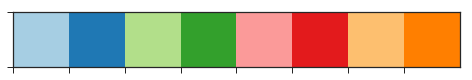

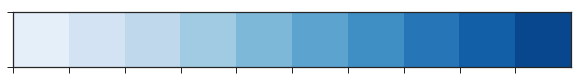

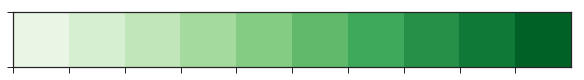

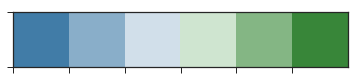

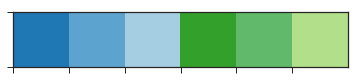

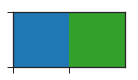

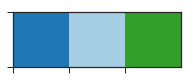

In [6]:
palette = sns.color_palette('Paired', 4)
blue_palette = sns.color_palette('Blues', 10)
green_palette = sns.color_palette('Greens', 10)
f_u_palette = [palette[1], blue_palette[-5], palette[0], palette[3], green_palette[-5], palette[2]]
appetizer_palette = [palette[1], palette[3]]
rmse_reg_palette = [palette[1], palette[0], palette[3]]

sns.palplot(sns.color_palette('Paired', 8))
sns.palplot(sns.color_palette('Blues', 10))
sns.palplot(sns.color_palette('Greens', 10))
sns.palplot(sns.diverging_palette(240, 128, n=6))
sns.palplot(f_u_palette)
sns.palplot(appetizer_palette)
sns.palplot(rmse_reg_palette)

plot_utils.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  blocked_mm_rt['algo'] = 'Blocked MM Only'
plot_utils.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lemp_rt['algo'] = 'LEMP'
plot_utils.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  fexipro_rt['algo'] = 'FEXIPRO'
plot_utils.py:311: Setting

lemp-paper-Netflix-noav-10 [ 0.03634368  0.02289567  0.02092233  0.01407273]
lemp-paper-Netflix-noav-50 [ 0.02083594  0.02016781  0.01975951  0.01621069]
lemp-paper-Netflix-noav-100 [ 0.02714644  0.02643271  0.02596297  0.02091473]
lemp-paper-KDD-50 [ 0.00559602  0.00623499  0.00694607  0.00789721]
nomad-Netflix-10-reg-0.05 [ 0.02562665  0.02474862  0.01988907  0.01325317]
nomad-Netflix-25-reg-0.05 [ 0.02006694  0.01748824  0.016311    0.01242602]
nomad-Netflix-50-reg-0.05 [ 0.02140196  0.02035698  0.02012382  0.01539344]
nomad-Netflix-100-reg-0.05 [ 0.02668236  0.02558164  0.02531299  0.02218804]
nomad-R2-10-reg-0.001 [ 0.01432535  0.01187299  0.01044197  0.00687934]
nomad-R2-25-reg-0.001 [ 0.01122895  0.00934731  0.00838076  0.00606536]
nomad-R2-50-reg-0.001 [ 0.01566469  0.01544412  0.01302904  0.00916949]
nomad-R2-100-reg-0.01 [ 0.07622439  0.07533909  0.07391827  0.06810967]
nomad-KDD-10-reg-1 [ 0.0058983   0.00439942  0.0036909   0.00403269]
nomad-KDD-25-reg-0.001 [ 0.00322712  0

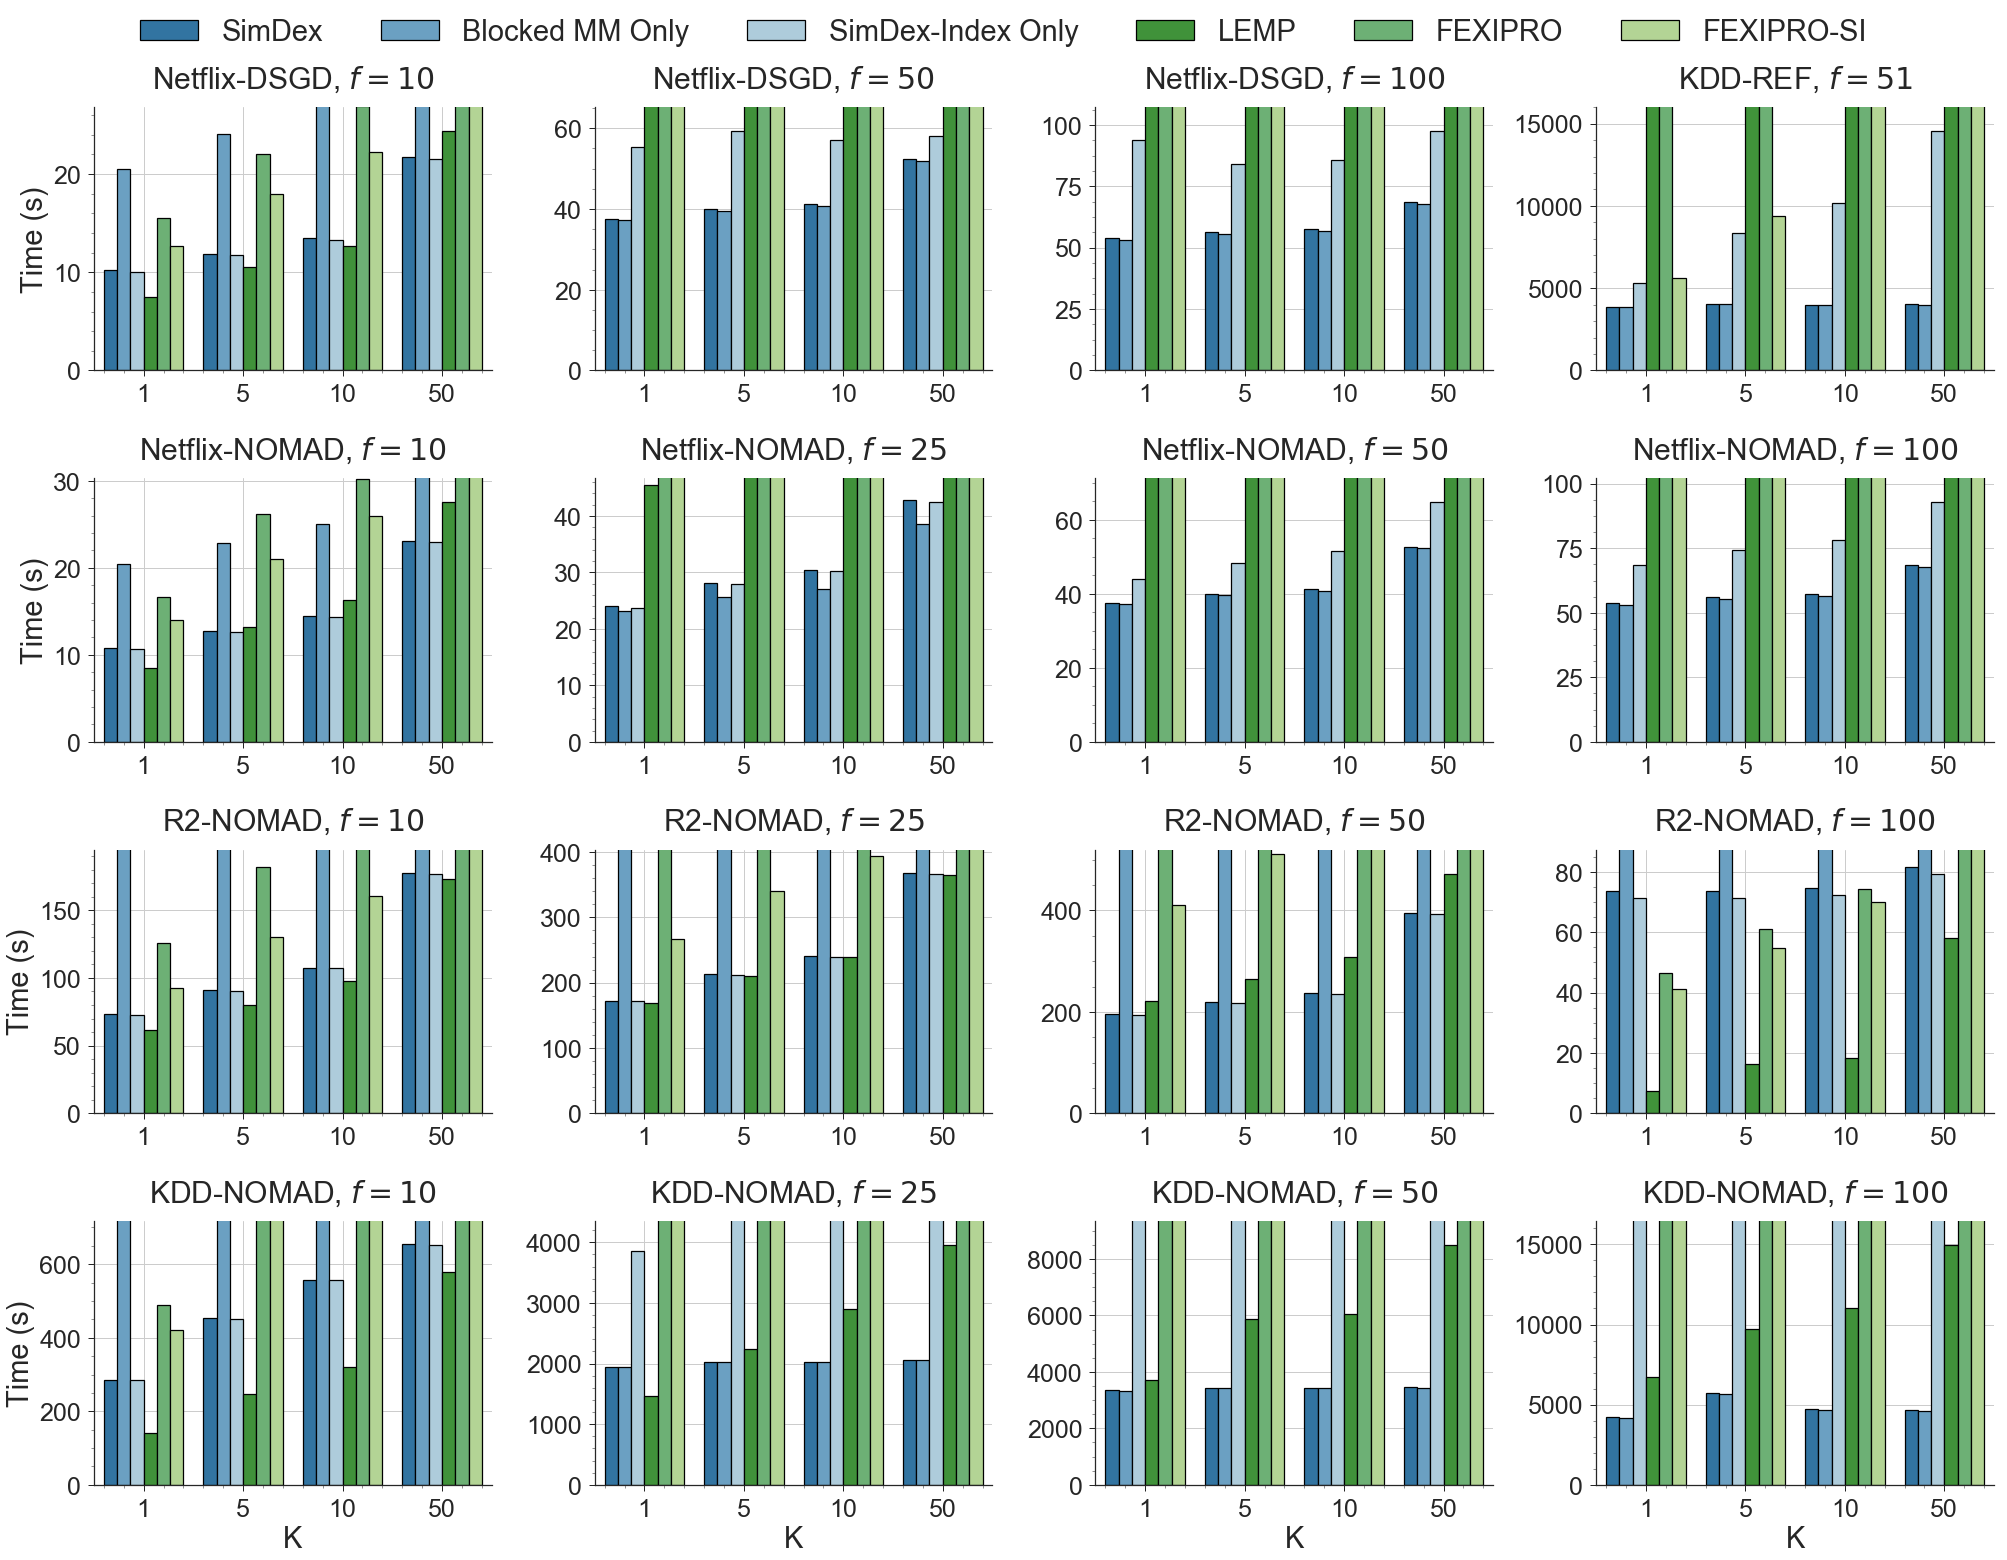

In [7]:
with sns.color_palette(f_u_palette):
    f_u_plots(simdex_df, lemp_df, blocked_mm_df, fexipro_df, fexipro_si_df, sampling_df, GOLD_STANDARD_MODELS,
          figsize=(28, 21), bbox_to_anchor=(0,0,1, 1.04))

plot_utils.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  blocked_mm_rt['algo'] = 'Blocked MM Only'
plot_utils.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lemp_rt['algo'] = 'LEMP'
plot_utils.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  fexipro_rt['algo'] = 'FEXIPRO'
plot_utils.py:222: Setting

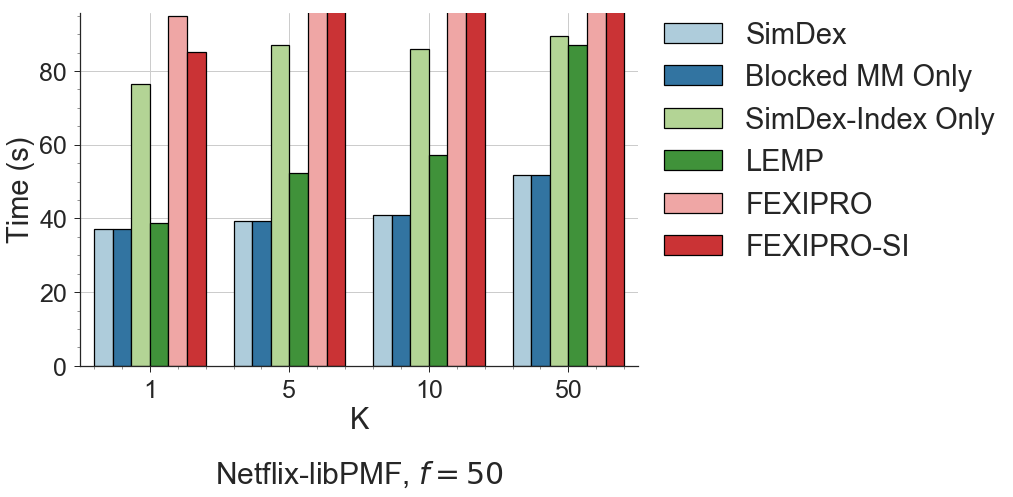

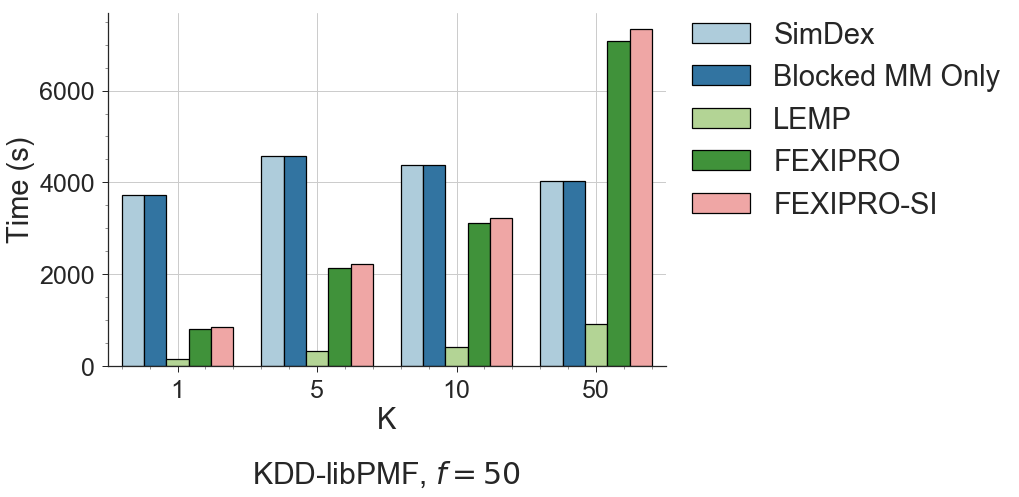

In [8]:
for model in ['fexipro-paper-Netflix-50', 'fexipro-paper-KDD-50']:
    f_u_plot_single(simdex_df, lemp_df, blocked_mm_df, fexipro_df, fexipro_si_df, sampling_df, model)


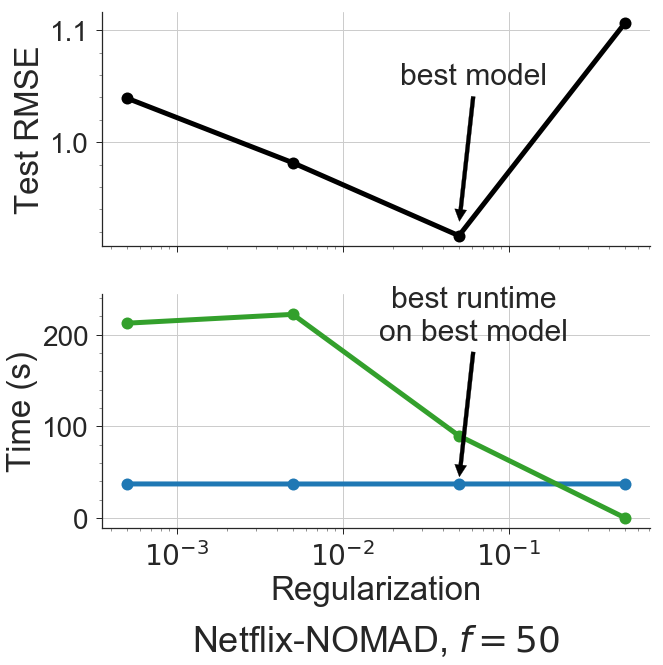

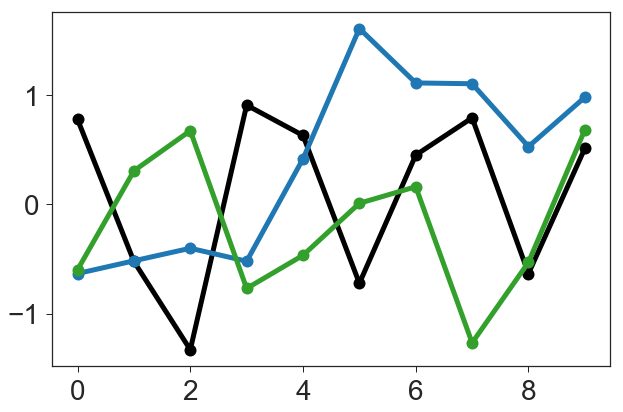

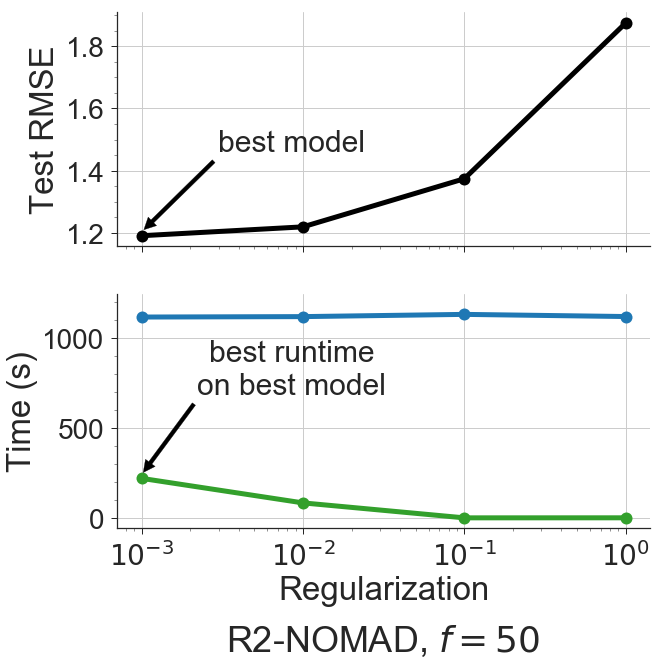

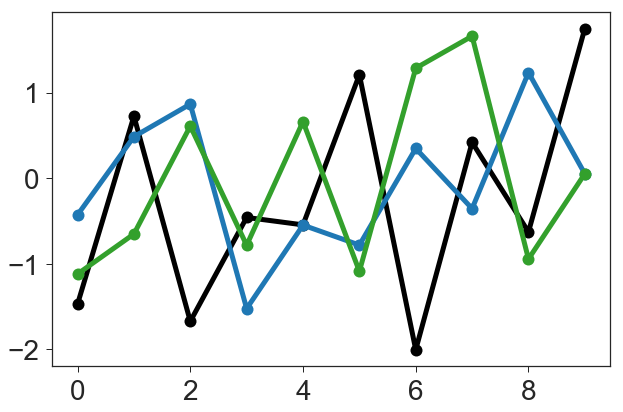

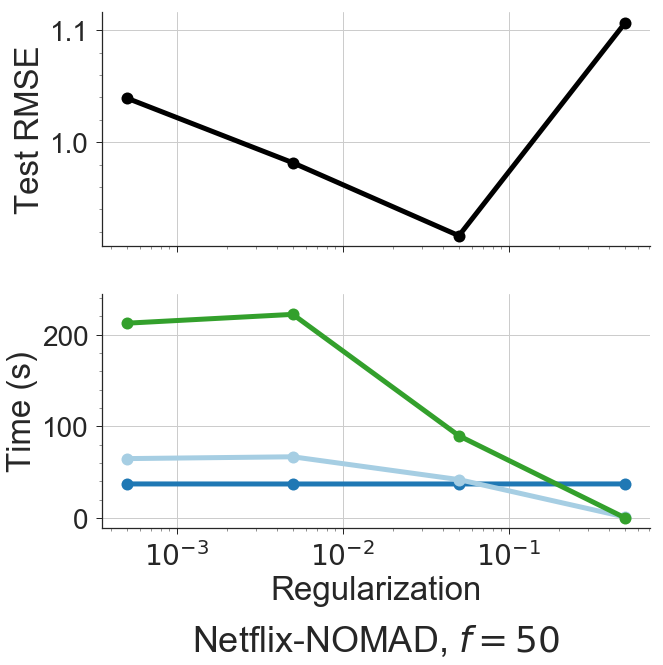

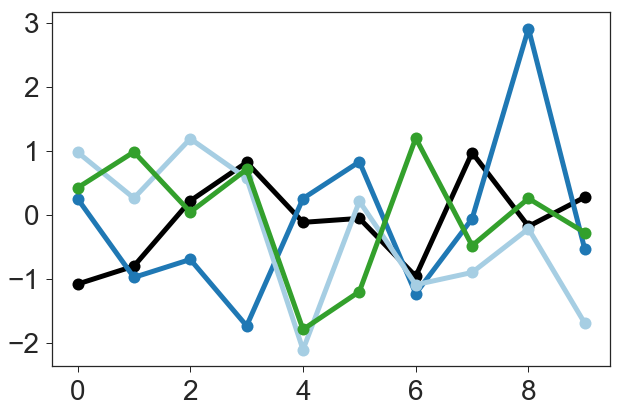

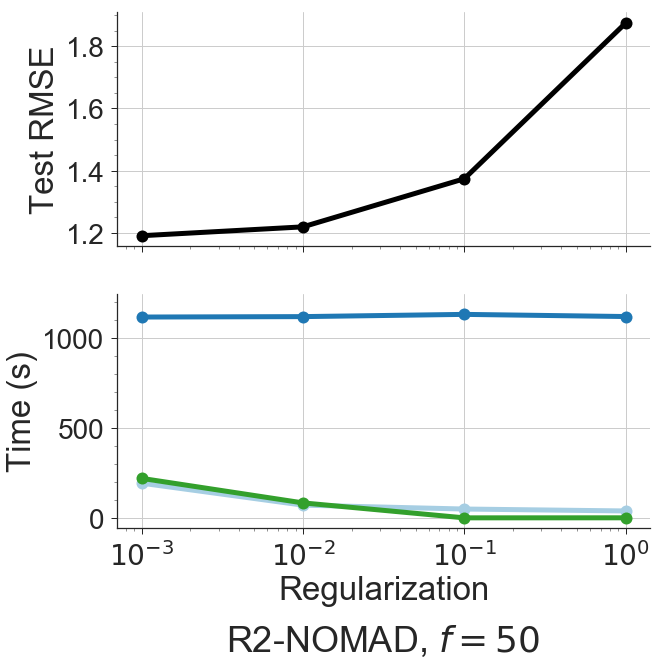

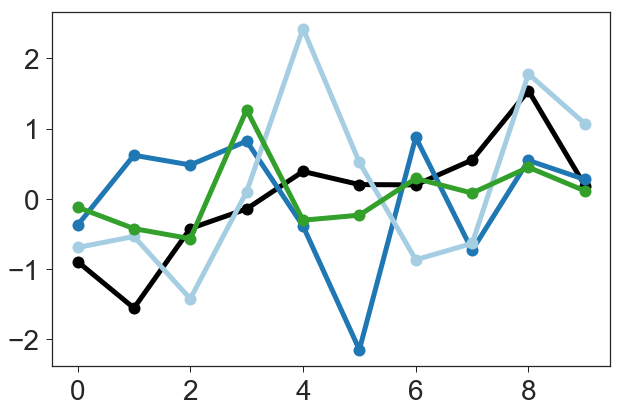

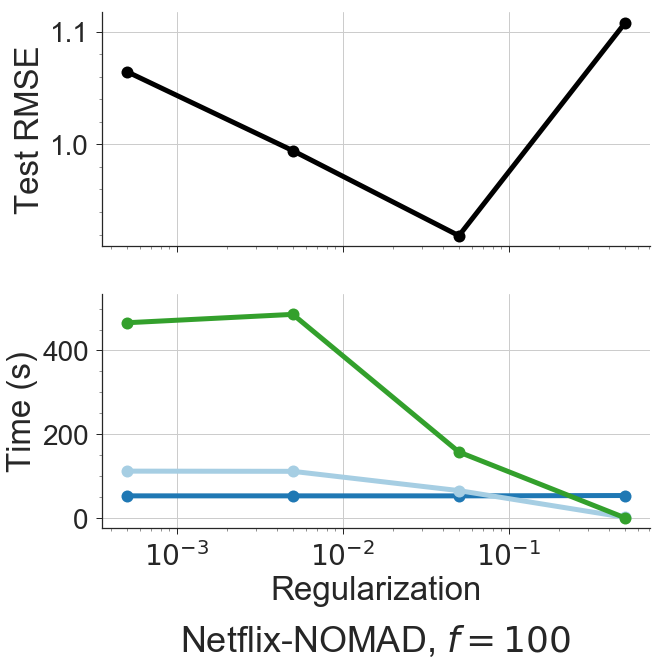

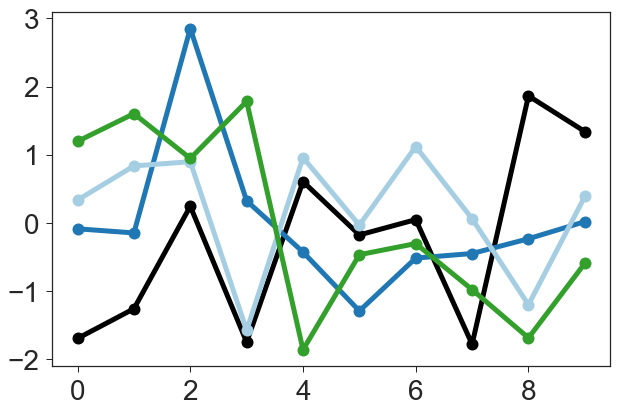

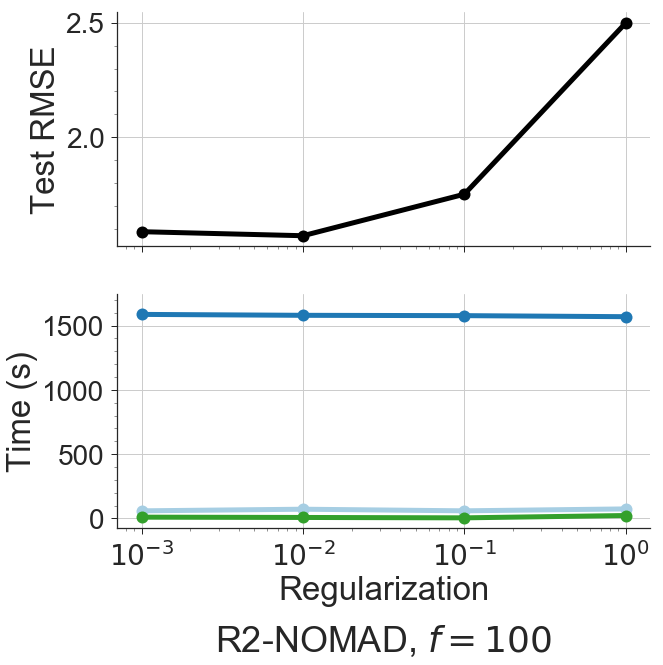

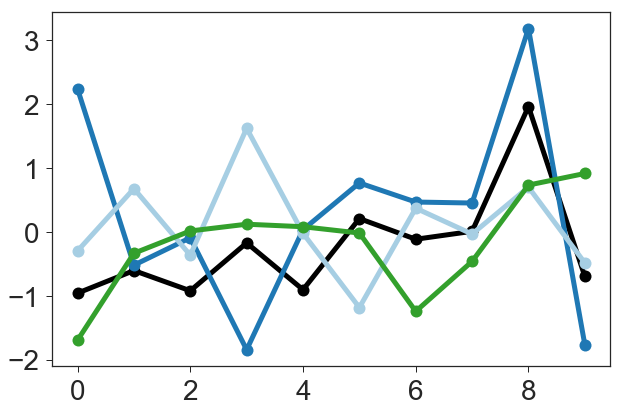

In [9]:
# custom settings for the line plots
plt.rcParams['font.size'] = 33
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 33
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['legend.fontsize'] = 27
plt.rcParams['lines.markersize'] = 12
plt.rcParams['lines.linewidth'] = 5

appetizer_models = [
    ('nomad-Netflix-50', NETFLIX_REGS, (15, 135)),
    ('nomad-R2-50', R2_REGS, (150, 75))    
]

all_models = appetizer_models + [
    ('nomad-Netflix-100', NETFLIX_REGS, (15, 150)),
    ('nomad-R2-100', R2_REGS, (15, 150)),
]
for add_simdex in [False, True]:
    models = all_models if add_simdex else appetizer_models
    _palette = rmse_reg_palette if add_simdex else appetizer_palette
    for model_prefix, regs, xy_text in models:
        _simdex_df = simdex_df if add_simdex else None
        fname = 'appetizer-' + model_prefix if not add_simdex else None
        with sns.color_palette(_palette):
            rmse_and_reg_plots(blocked_mm_df, lemp_df, rmse_df, model_prefix, regs,
                               simdex_df=_simdex_df, fname=fname, figsize=(10, 10),
                               bbox_to_anchor=(0,0,1,1.05), title=True, y_title=-0.55,
                               annotate=not add_simdex, xy_text=xy_text)
            rmse_and_reg_legend(add_simdex)
     
# return to normal
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4        
sns.set_palette('Paired', 10)


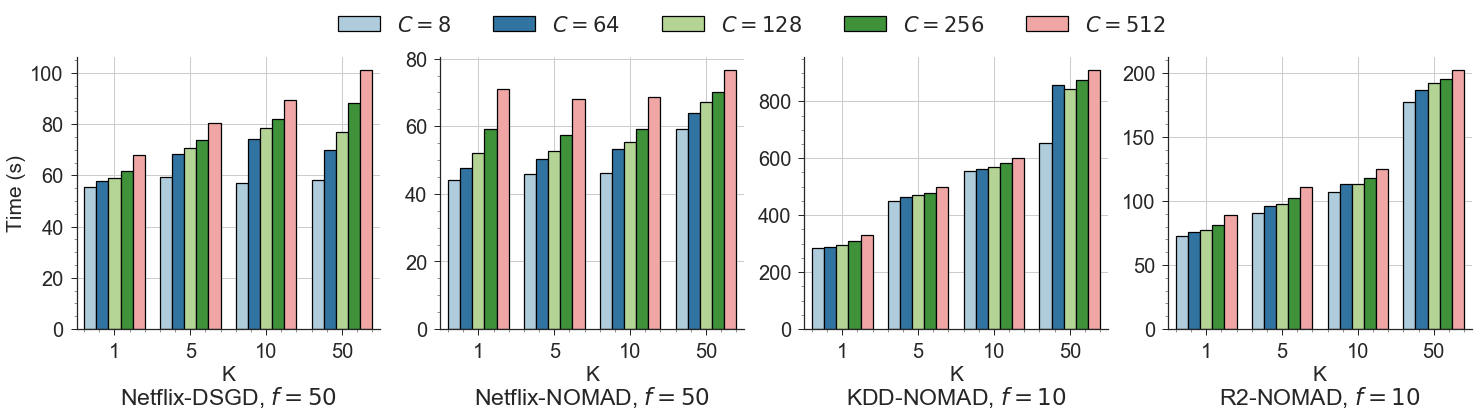

In [10]:
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['legend.fontsize'] = 21
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 21
num_clusters_vs_runtime(simdex_df, ['lemp-paper-Netflix-noav-50',
                                    'nomad-Netflix-50-reg-0.05',
                                    'nomad-KDD-10-reg-1',
                                    'nomad-R2-10-reg-0.001',
                                   ], figsize=(25, 5), y_title=-0.3,
                            bbox_to_anchor=(0,0,1,1.05), min_value=1, max_value=1024)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.labelsize'] = 29

0.728975428881 480189
0.740907253265 480189
4.56547932375 1823179
70.4420596662 27684


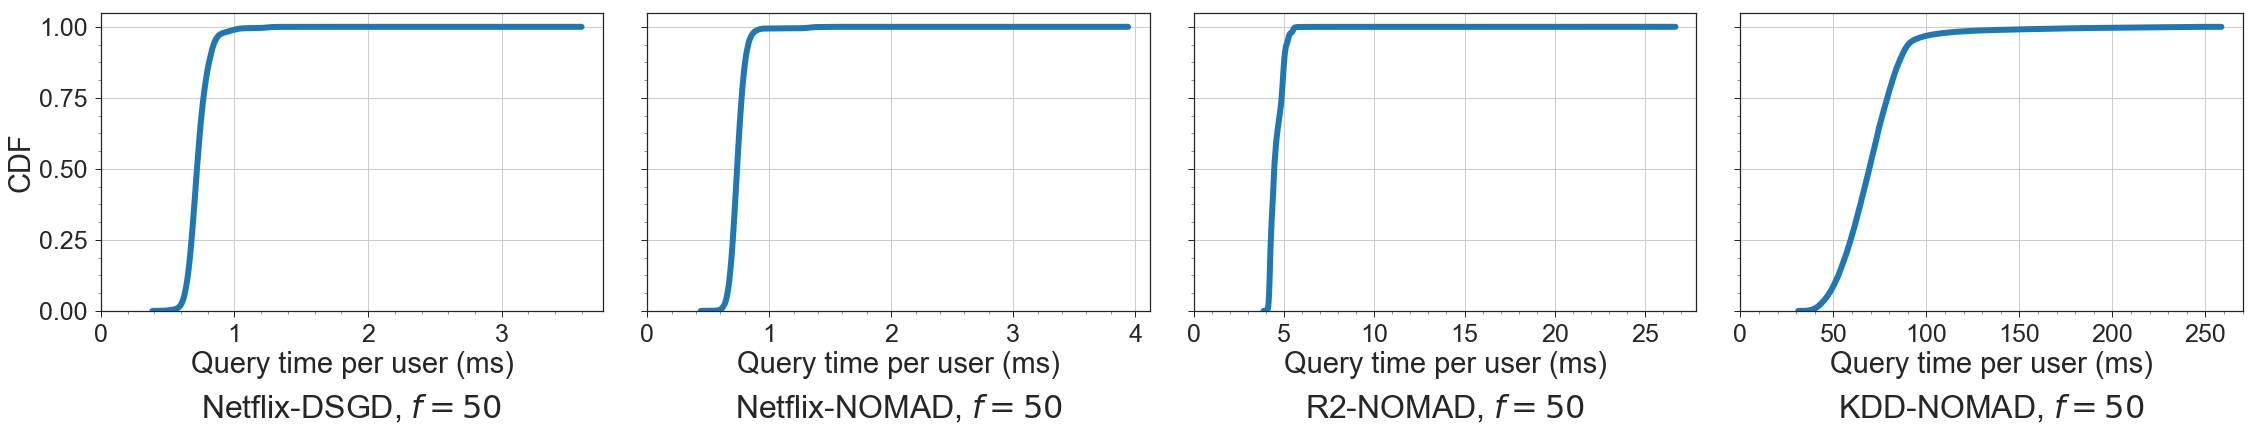

In [11]:
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['lines.linewidth'] = 6
with sns.color_palette(f_u_palette):
    point_query_time(['lemp-paper-Netflix-noav-50', 'nomad-Netflix-50-reg-0.05',
                      'nomad-R2-50-reg-0.001', 'nomad-KDD-50-reg-1'], csv_dir='point-query-stats/',
                     figsize=(32, 6.5), sample_fraction=1.0, y_title=-0.38)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['lines.linewidth'] = 4

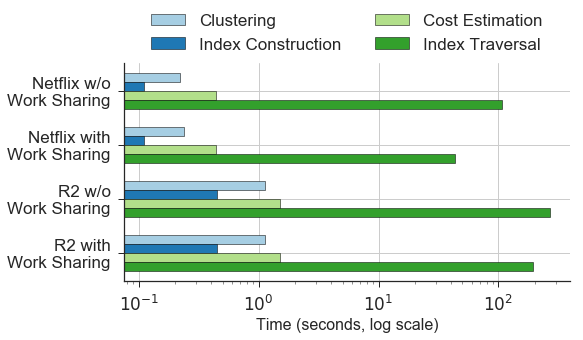

In [12]:
plt.rcParams['font.size'] = 25
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['lines.markersize'] = 11
plt.rcParams['lines.linewidth'] = 2.50

factor_analysis(figsize=(8,4))